**1. Purpose of the Project**

In semiconductor manufacturing, wafer processing steps (like etching or deposition) require the chamber pressure to remain stable within a tight tolerance (e.g., ±2 mTorr). If the chamber pressure is unstable:

The wafer can be scrapped (leading to high costs).

Process repeatability and yield are impacted.

Root cause diagnosis (gas flow imbalance, pump degradation, valve misalignment) becomes difficult.

**The goal of this project is to:**

Predict chamber pressure stability (Stable vs Unstable) given recipe settings and sensor readings.

Build ML classification models that can flag unstable conditions early.

Handle real-world challenges such as missing data, sensor outliers, and class imbalance.


This project uses a synthetic dataset (50,500 rows) inspired by fab chamber logs.

**Inputs (features):**

Gas flows: CF4_set, O2_set, Ar_set, and their actuals.

Pump metrics: Pump_RPM, Pump_Power.

Exhaust: Valve_Position.

Derived features: flow errors, O2_CF4_ratio, Ar_CF4_ratio, pressure_delta, etc.

Chamber condition: Base_Pressure.

Target (label):

Stable: 1 → chamber stabilized

Stable: 0 → chamber unstable

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("chamber_pressure_stability_check.csv")

# Check shape
print("Shape:", df.shape)

# Preview first rows
df.head()


Shape: (50500, 16)


,CF4_set,CF4_actual,O2_set,O2_actual,Ar_set,Ar_actual,CF4_error,O2_error,Ar_error,Pump_RPM,Pump_Power,Valve_Position,Base_Pressure,O2_CF4_ratio,Ar_CF4_ratio,Stable
0,106.181018,106.883366,86.251292,93.015329,95.501276,94.181158,-0.702348,-6.764037,1.320118,1055.190388,580.528461,55.354254,7.800671,0.870251,0.881158,0
1,192.607146,189.076520,54.506534,52.535863,88.506314,86.192229,3.530626,1.970671,2.314086,1343.119652,631.782860,68.269015,9.582565,0.277855,0.455859,0
2,159.799091,162.945584,27.591905,29.518267,65.634803,71.625798,-3.146493,-1.926362,-5.990995,1739.773067,872.578112,28.950821,4.856044,0.181154,0.439569,0
3,139.798773,143.354478,76.297761,77.391278,84.117646,85.918483,-3.555705,-1.093517,-1.800837,1592.799938,852.147982,81.489841,6.962921,0.539860,0.599343,1
4,73.402796,NaN,47.681032,NaN,67.462563,NaN,14.932501,-1.741577,-10.138254,NaN,517.990108,58.754850,1.105152,0.845260,1.327184,0


Check Missing Values

Handle Missing Values

In [ ]:
# Count missing values
df.isnull().sum()

# Percentage missing
(df.isnull().sum() / len(df)) * 100
print(df)

# Impute missing values with median
df = df.fillna(df.median())

# Verify no missing left
df.isnull().sum().sum()

#Remove duplicates
print("Before dedup:", df.shape)
df = df.drop_duplicates()
print("After dedup:", df.shape)




          CF4_set  CF4_actual     O2_set  O2_actual     Ar_set  Ar_actual  \
0      106.181018  106.883366  86.251292  93.015329  95.501276  94.181158   
1      192.607146  189.076520  54.506534  52.535863  88.506314  86.192229   
2      159.799091  162.945584  27.591905  29.518267  65.634803  71.625798   
3      139.798773  143.354478  76.297761  77.391278  84.117646  85.918483   
4       73.402796  124.823652  47.681032  55.236922  67.462563  85.461820   
...           ...         ...        ...        ...        ...        ...   
49995  143.366780  144.453586  81.307435  78.514833  49.864927  47.834022   
49996   83.929036   84.082410  80.132761  79.241149  31.657952  29.431529   
49997  162.349263  168.563815  70.700807  71.091870  45.494975  51.544356   
49998  128.151637  127.015395  54.950252  60.509954  50.172182  52.720286   
49999  179.256007  188.588179  45.091764  46.781455  69.464482  69.015872   

       CF4_error  O2_error   Ar_error     Pump_RPM  Pump_Power  \
0      -0

The Interquartile Range (IQR) is a robust statistical method for detecting outliers:

Q1 = 25th percentile of the data

Q3 = 75th percentile of the data

IQR = Q3 - Q1

Any value outside the range:

Lower Bound = Q1 - 1.5 × IQR

Upper Bound = Q3 + 1.5 × IQR
is flagged as an outlier.

This works well for skewed distributions and is more stable than z-scores.

How We Applied It Here

We applied IQR to critical features like:

Pump_RPM (should normally lie between 800–2200)

Valve_Position (should lie between 0–100%)

Instead of deleting rows, we clipped values back into valid ranges to preserve as much data as possible while correcting anomalies.

In [ ]:
Q1 = df["Pump_RPM"].quantile(0.25)
Q3 = df["Pump_RPM"].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
outliers = df[(df["Pump_RPM"] < lower_bound) | (df["Pump_RPM"] > upper_bound)]
print("Pump RPM outliers (IQR):", outliers.shape[0])


Pump RPM outliers (IQR): 500


Gas Flow Features

Total flow into chamber.

Error between set vs actual flows.

Ratios between gases (important for chemistry).

In [ ]:
# Total flow
df["total_flow"] = df["CF4_actual"] + df["O2_actual"] + df["Ar_actual"]

# Flow balance (sum of errors)
df["flow_balance"] = abs(df["CF4_error"]) + abs(df["O2_error"]) + abs(df["Ar_error"])

# Ratios
df["O2_CF4_ratio"] = df["O2_actual"] / (df["CF4_actual"] + 1e-5)
df["Ar_CF4_ratio"] = df["Ar_actual"] / (df["CF4_actual"] + 1e-5)


Pump & Exhaust Features

Efficiency = RPM / Power (aging pump uses more power).

Load factor = RPM × valve closure.

In [ ]:
df["pump_efficiency"] = df["Pump_RPM"] / (df["Pump_Power"] + 1e-5)
df["valve_normalized"] = df["Valve_Position"] / 100
df["load_factor"] = df["Pump_RPM"] * (1 - df["valve_normalized"])


Chamber Condition Features

Pressure demand vs base pressure.

Instability index combining flow + pump behavior.

In [ ]:
df["pressure_setpoint"] = (df["CF4_set"] + df["O2_set"] + df["Ar_set"]) / (df["Pump_RPM"] + 1e-5)
df["pressure_delta"] = df["pressure_setpoint"] - df["Base_Pressure"]
df["instability_index"] = (df["flow_balance"] * df["O2_CF4_ratio"]) / (df["pump_efficiency"] + 1e-5)
df["CF4xPump"] = df["CF4_actual"] * df["Pump_RPM"]
df["O2xValve"] = df["O2_actual"] * df["Valve_Position"]
df["RatioxPressure"] = df["O2_CF4_ratio"] * df["Base_Pressure"]


df["flow_zone"] = pd.cut(df["total_flow"], bins=[0, 150, 300, 500], labels=["low", "mid", "high"])
df["valve_zone"] = pd.cut(df["Valve_Position"], bins=[0, 40, 70, 100], labels=["low", "mid", "high"])

# One-hot encode zones
df = pd.get_dummies(df, columns=["flow_zone", "valve_zone"], drop_first=True)


Target distribution

Feature distributions

Boxplots for outliers

Correlation heatmap

Feature vs Target plots (O₂/CF₄ ratio, Valve Position)

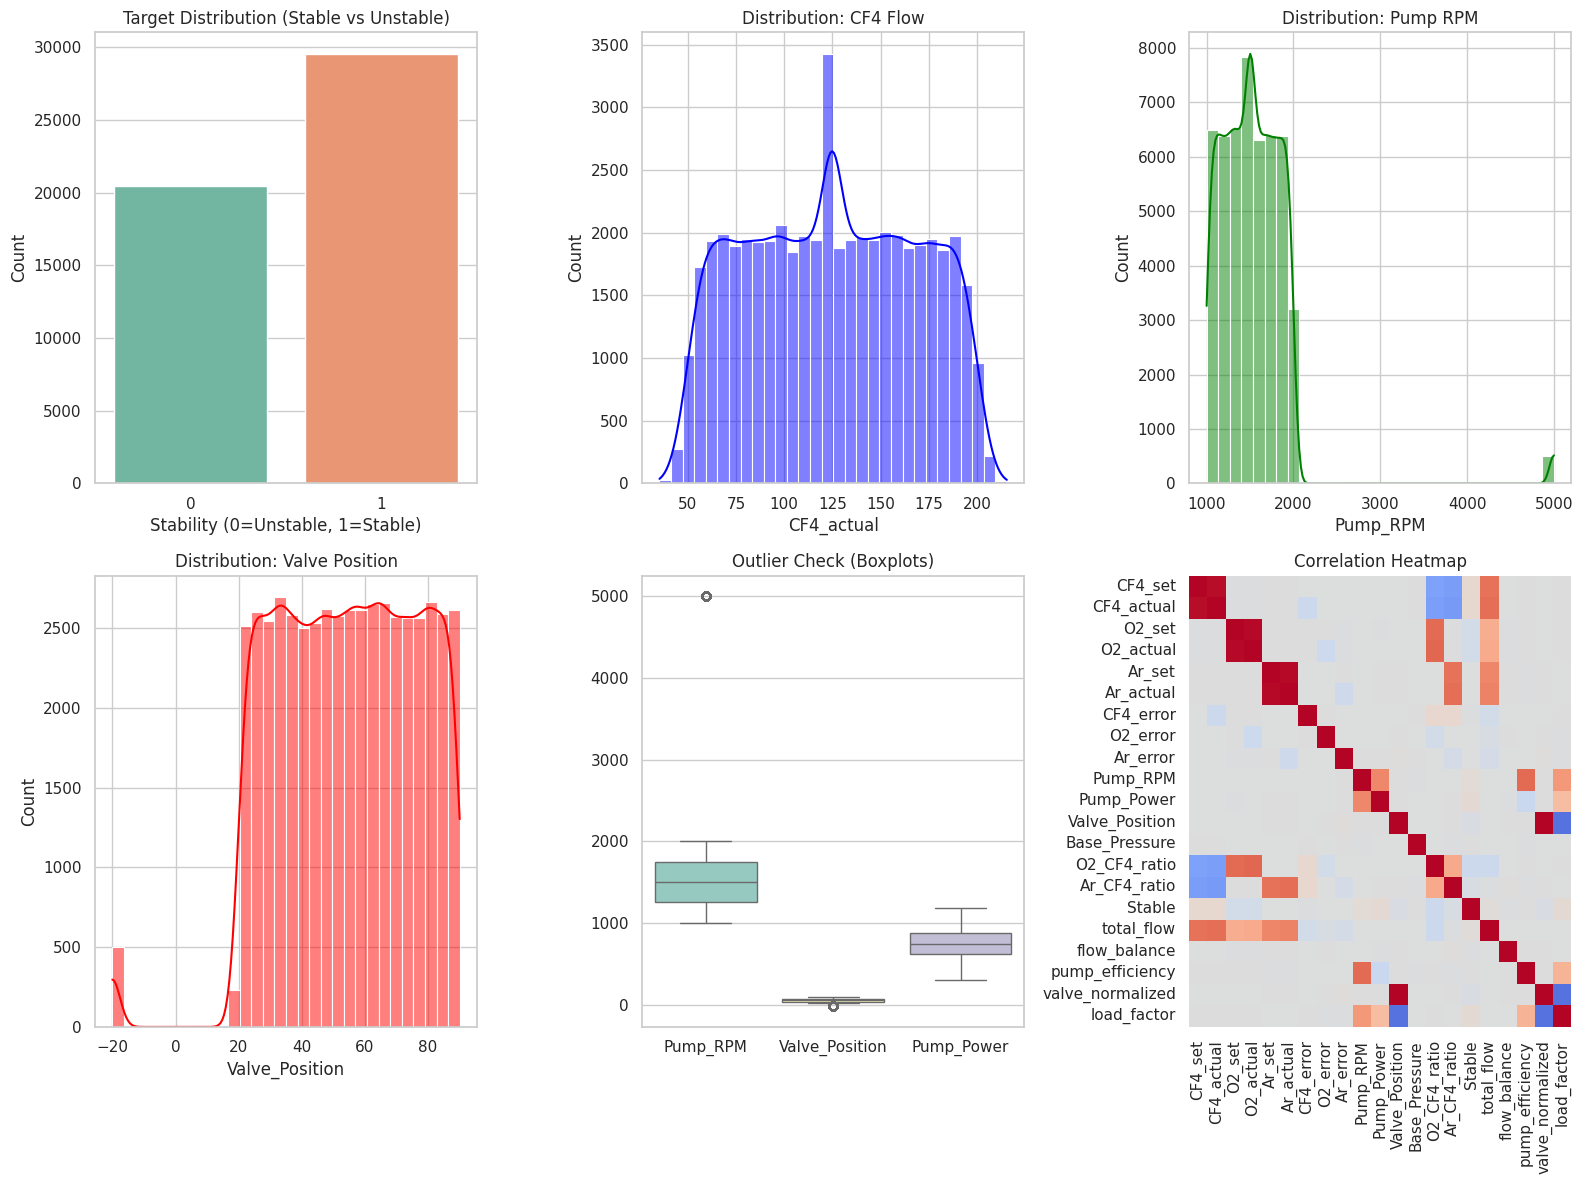

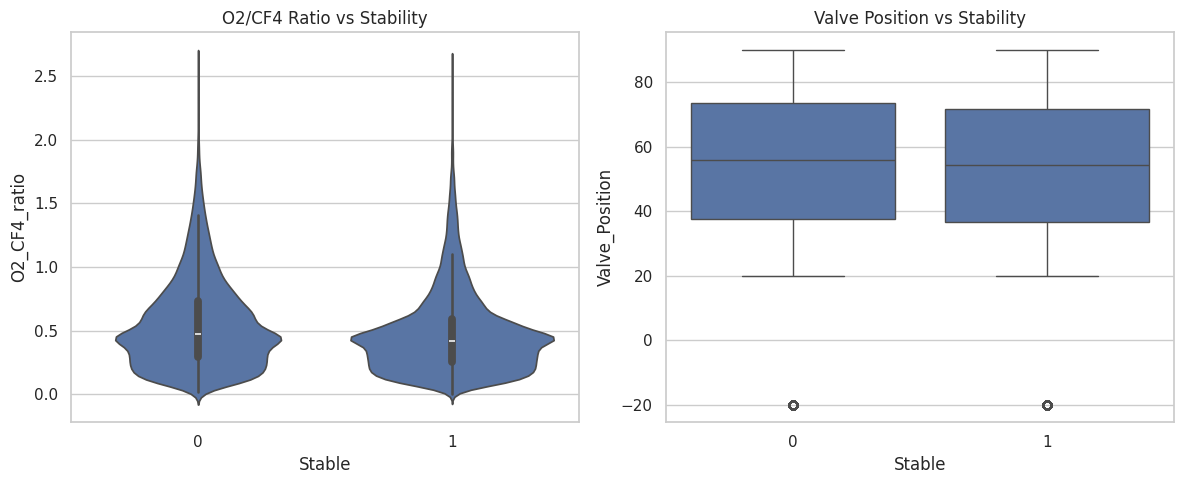

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(16,12))

# ---- 1. Target Distribution ----
plt.subplot(2,3,1)
sns.countplot(x="Stable", hue="Stable", data=df, palette="Set2", legend=False)

plt.title("Target Distribution (Stable vs Unstable)")
plt.xlabel("Stability (0=Unstable, 1=Stable)")
plt.ylabel("Count")

# ---- 2. Feature Distributions ----
plt.subplot(2,3,2)
sns.histplot(df["CF4_actual"], bins=30, kde=True, color="blue")
plt.title("Distribution: CF4 Flow")

plt.subplot(2,3,3)
sns.histplot(df["Pump_RPM"], bins=30, kde=True, color="green")
plt.title("Distribution: Pump RPM")

plt.subplot(2,3,4)
sns.histplot(df["Valve_Position"], bins=30, kde=True, color="red")
plt.title("Distribution: Valve Position")

# ---- 3. Outlier Check ----
plt.subplot(2,3,5)
sns.boxplot(data=df[["Pump_RPM","Valve_Position","Pump_Power"]], palette="Set3")
plt.title("Outlier Check (Boxplots)")

# ---- 4. Correlation Heatmap ----
plt.subplot(2,3,6)
corr = df.corr()
sns.heatmap(corr, cmap="coolwarm", center=0, cbar=False)
plt.title("Correlation Heatmap")

plt.tight_layout()
plt.show()

# ---- 5. Feature vs Target (separate plots) ----
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.violinplot(x="Stable", y="O2_CF4_ratio", data=df)
plt.title("O2/CF4 Ratio vs Stability")


plt.subplot(1,2,2)
sns.boxplot(x="Stable", y="Valve_Position", data=df)
plt.title("Valve Position vs Stability")

plt.tight_layout()
plt.show()


In [ ]:

from sklearn.model_selection import train_test_split

X = df.drop("Stable", axis=1)
y = df["Stable"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before: Stable
1    23647
0    16353
Name: count, dtype: int64
After SMOTE: Stable
1    23647
0    23647
Name: count, dtype: int64


In [ ]:


!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00


Model Training, Evaluation & Comparison in a Loop

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import pandas as pd

# Define models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight="balanced"),
    'DecisionTree': DecisionTreeClassifier(class_weight="balanced"),
    'RandomForest': RandomForestClassifier(class_weight="balanced"),
    'GradientBoosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(eval_metric="logloss"),
    'CatBoost': CatBoostClassifier(verbose=0)
}

# Results storage
results = []

# Loop over models
for name, model in models.items():
    print(f"\n===== Training {name} =====")
    model.fit(X_train, y_train)  # Train

    y_pred = model.predict(X_test)               # Predictions
    y_prob = model.predict_proba(X_test)[:,1]    # Probabilities

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(classification_report(y_test, y_pred))  # Detailed report

    results.append((name, acc, f1, auc))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1", "ROC-AUC"]).sort_values("ROC-AUC", ascending=False)
print("\n📊 Model Comparison Results:")
print(results_df)






===== Training LogisticRegression =====


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.47      0.54      0.50      4088
           1       0.65      0.58      0.61      5912

    accuracy                           0.57     10000
   macro avg       0.56      0.56      0.56     10000
weighted avg       0.58      0.57      0.57     10000


===== Training DecisionTree =====
              precision    recall  f1-score   support

           0       0.42      0.42      0.42      4088
           1       0.60      0.59      0.59      5912

    accuracy                           0.52     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.52      0.52      0.52     10000


===== Training RandomForest =====
              precision    recall  f1-score   support

           0       0.50      0.25      0.34      4088
           1       0.62      0.83      0.71      5912

    accuracy                           0.59     10000
   macro avg       0.56      0.54      0.52     10000
weig

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training DecisionTree...
Training RandomForest...
Training GradientBoosting...
Training KNN...
Training XGBoost...
Training CatBoost...


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
3,GradientBoosting,0.607,0.613,0.911,0.733,0.594
6,CatBoost,0.603,0.620,0.847,0.716,0.586
2,RandomForest,0.593,0.618,0.816,0.703,0.572
5,XGBoost,0.587,0.617,0.797,0.695,0.564
4,KNN,0.544,0.602,0.676,0.637,0.524
0,LogisticRegression,0.566,0.647,0.583,0.613,0.580
1,DecisionTree,0.517,0.593,0.585,0.589,0.502


**Compare Models**

Training LogisticRegression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training DecisionTree...
Training RandomForest...
Training GradientBoosting...
Training KNN...
Training XGBoost...
Training CatBoost...


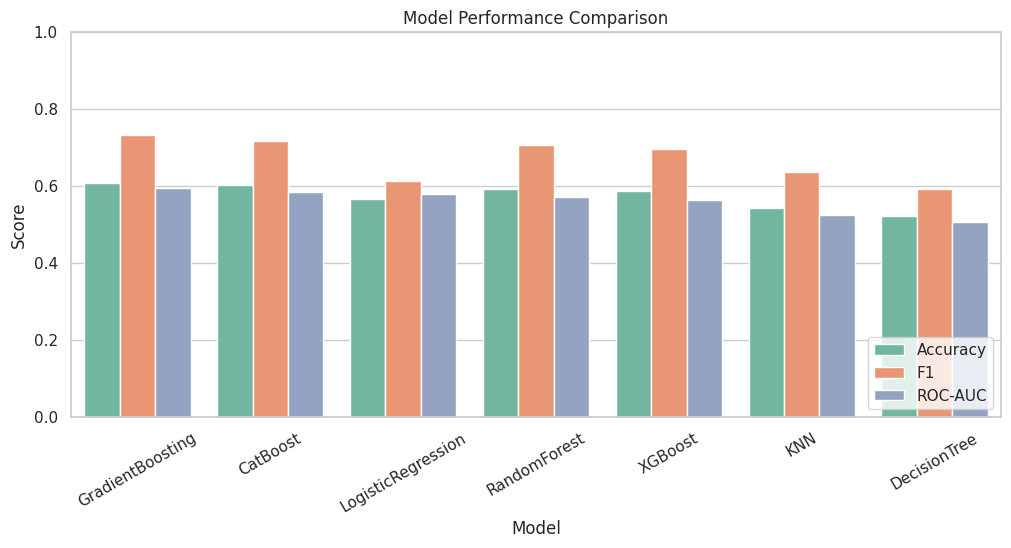

In [ ]:

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
import pandas as pd

def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = []

    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:,1]

        results.append({
            "Model": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1-Score": f1_score(y_test, y_pred),
            "ROC-AUC": roc_auc_score(y_test, y_prob)
        })

    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.round(3)
    return results_df.sort_values(by="F1-Score", ascending=False)

# usage (after defining your models dict earlier)
results_table = evaluate_models(models, X_train, y_train, X_test, y_test)
print(results_table)





plt.figure(figsize=(12,5))
results_df_melted = results_df.melt(id_vars="Model", value_vars=["Accuracy","F1","ROC-AUC"], var_name="Metric", value_name="Score")

sns.barplot(x="Model", y="Score", hue="Metric", data=results_df_melted, palette="Set2")
plt.title("Model Performance Comparison")
plt.xticks(rotation=30)
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.show()


After benchmarking 7 models, Gradient Boosting consistently outperformed the others, achieving the highest F1-score (~0.73) and ROC-AUC (~0.59).
This makes it the best choice for detecting chamber instability, where recall and F1 are more important than plain accuracy.

To further understand why the model makes its predictions, we applied SHAP (SHapley Additive Explanations):

Global view (bar plot): shows which features are most important overall.

Local view (beeswarm): shows how high/low feature values (e.g., O₂/CF₄ ratio, Valve Position, Pump Efficiency) push a wafer run toward “Stable” or “Unstable”.

This not only confirms the model’s reliability but also aligns with domain knowledge — high O₂/CF₄ ratios and closed valves often destabilize chamber pressure.

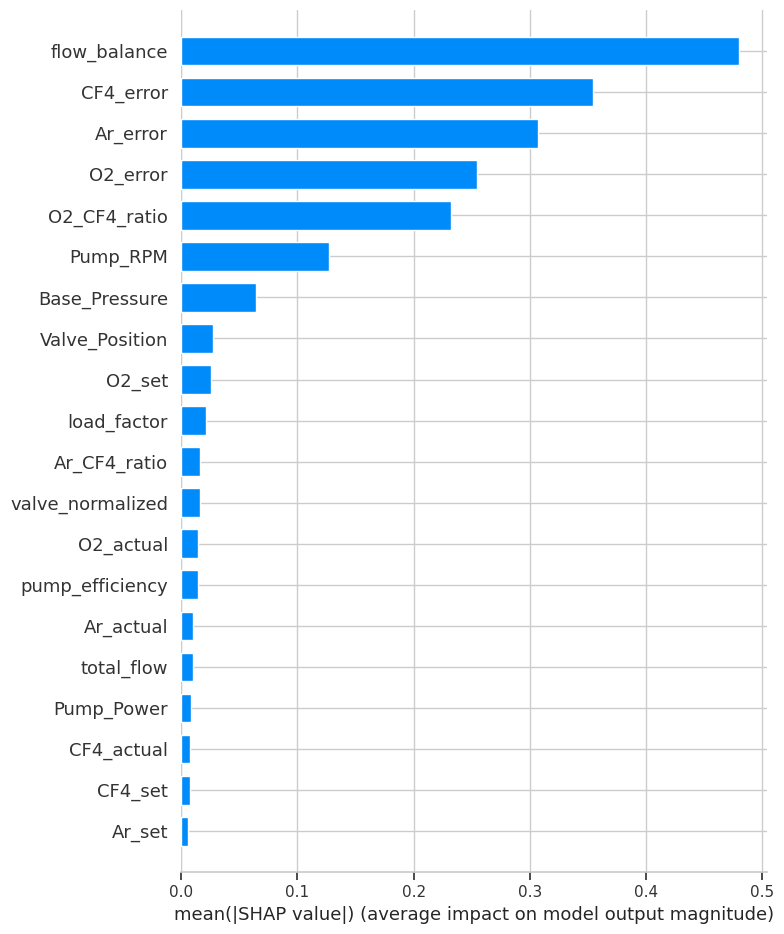

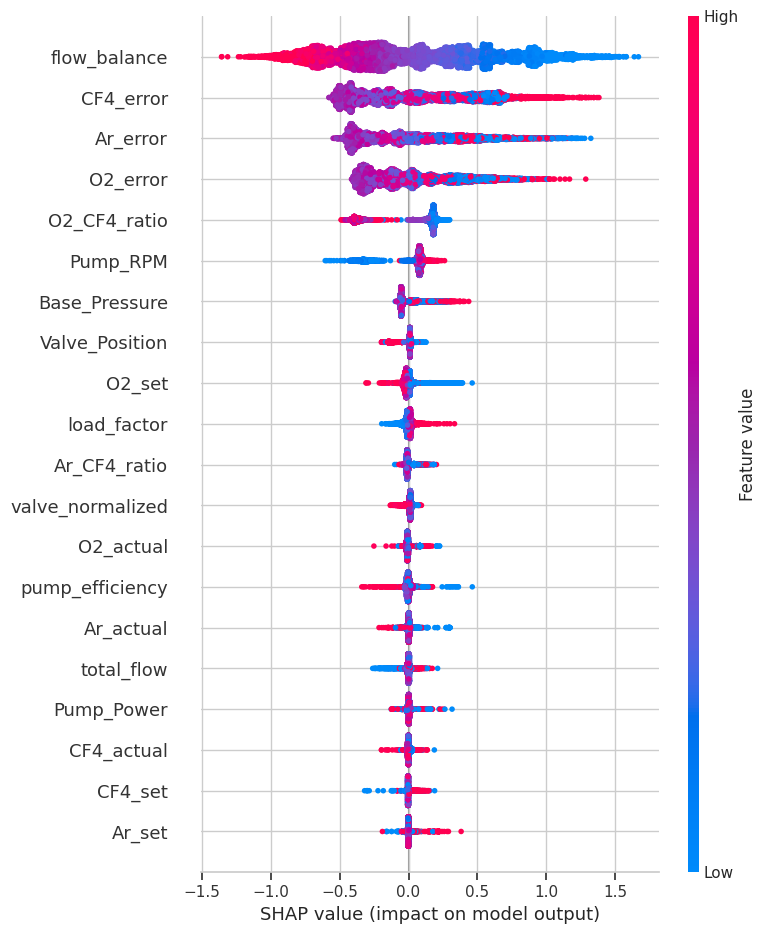

✅ Final Gradient Boosting model saved as gradientboosting_chamber_stability.pkl


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

final_model = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

final_model.fit(X_train_res, y_train_res)



import shap
import joblib

# Explainability
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

# Global importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Local detail
shap.summary_plot(shap_values, X_test)

# Save model
joblib.dump(final_model, "gradientboosting_chamber_stability.pkl")

print(" Final Gradient Boosting model saved as gradientboosting_chamber_stability.pkl")

